In [1]:
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 10)
pd.set_option("display.max_colwidth", 50)
pd.set_option("display.width", 120)

In [2]:
import warnings

warnings.simplefilter("ignore", RuntimeWarning)

In [3]:
# local paths
data_dir_src = Path('data/preprocess')
data_dir_dst = Path('data/eda')
data_dir_dst.mkdir(parents=True, exist_ok=True)

In [4]:
expression = pd.read_parquet(data_dir_src / 'expression.parquet')
print(expression.head())
print(expression.shape)

                 ARHGEF10L    HIF3A   RNF17    RNF10    RNF11  ...     PTRF   BCL6B    GSTK1    SELP     SELS
TCGA-69-7978-01     9.9898   4.2598  0.4181  10.3657  11.1718  ...  12.7565  8.2668  11.2400  6.1209   9.8977
TCGA-62-8399-01    10.4257  11.6239  0.0000  11.5489  11.0200  ...  12.2100  8.5437  10.3491  8.6398   9.7315
TCGA-78-7539-01     9.6264   9.1362  1.1231  11.6692  10.4679  ...  10.6498  6.1814  11.1659  6.0970  10.3540
TCGA-73-4658-01     9.2078   5.0288  0.0000  11.6209  11.3414  ...  13.0036  8.9786  10.6777  8.4187  10.3142
TCGA-44-6775-01    10.0039   4.0573  1.0069  11.1721  11.0969  ...  12.7727  7.5911  10.3340  7.3311  10.0039

[5 rows x 20530 columns]
(506, 20530)


# column types

In [5]:
# all genes are float64
expression.dtypes.value_counts()

float64    20530
Name: count, dtype: int64

# missing values

In [6]:
# no genes with missing values
expression.isna().sum().sum()

np.int64(0)

# variance

In [7]:
variance = expression.var()
variance.max()

np.float64(29.2368504282824)

In [8]:
# 338 genes with zero variance
(variance == 0).sum()

np.int64(338)

In [9]:
# 93% of genes have var >= 0.1
# 87% of genes have var >= 0.2
# 74% of genes have var >= 0.3
thresholds = np.linspace(0, 1, 11)
pd.Series([(variance >= thresh).mean() for thresh in thresholds], index=thresholds)

0.0    1.000000
0.1    0.933999
0.2    0.869459
0.3    0.740136
0.4    0.634194
0.5    0.561130
0.6    0.507258
0.7    0.465416
0.8    0.430979
0.9    0.401656
1.0    0.372918
dtype: float64

(0.0, 1.0)

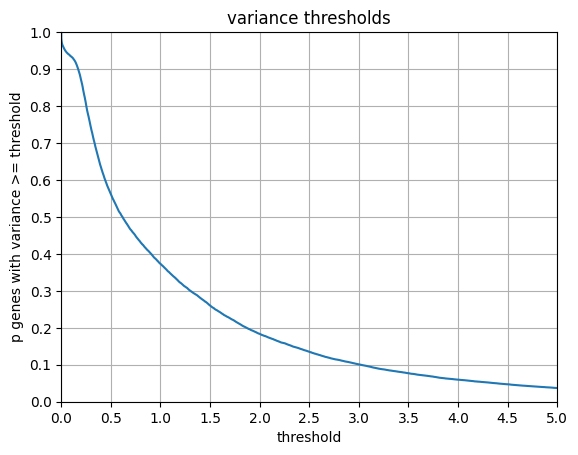

In [31]:
ax = variance\
    .value_counts()\
    .sort_index(ascending=False)\
    .cumsum()\
    .div(len(variance))\
    .plot(grid=True)
ax.set_title('variance thresholds')
ax.set_xlabel('threshold')
ax.set_ylabel('p genes with variance >= threshold')
ax.set_xticks(np.arange(0, variance.max(), .5))
ax.set_xlim((0, 5))
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_ylim((0, 1))

In [11]:
# remove genes with zero variance
# expression = expression.loc[:, expression.var() > 0]
# print(expression.shape)


# proportion of zero values

In [12]:
p_zero = expression.apply(lambda x: (x == 0).mean())

In [13]:
# 67% of genes have no zeros
# 80% of genes have <= 10% zeros
thresholds = np.linspace(0, 1, 11)
pd.Series([(p_zero <= x).mean() for x in thresholds], index=thresholds)

0.0    0.656698
0.1    0.784413
0.2    0.811495
0.3    0.831515
0.4    0.850122
0.5    0.865222
0.6    0.878714
0.7    0.892694
0.8    0.910083
0.9    0.931466
1.0    1.000000
dtype: float64

(0.0, 1.0)

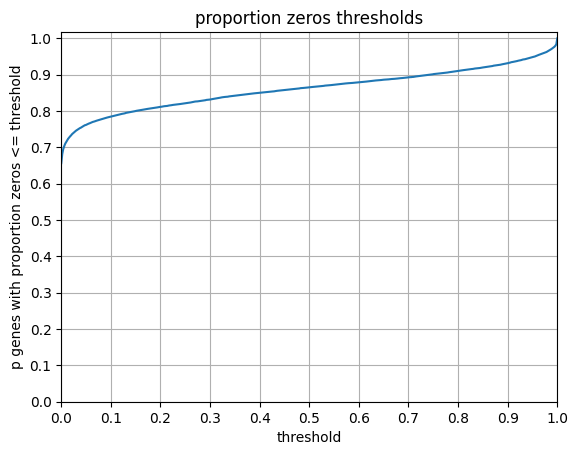

In [14]:
ax = p_zero\
    .value_counts()\
    .sort_index(ascending=True)\
    .cumsum()\
    .div(len(variance))\
    .plot(grid=True)
ax.set_title('proportion zeros thresholds')
ax.set_xlabel('threshold')
ax.set_ylabel('p genes with proportion zeros <= threshold')
ax.set_xticks(np.arange(0, variance.max(), .1))
ax.set_xlim((0, 1))
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_xlim((0, 1))

In [15]:
# remove genes with >10% zeros
# expression = expression.loc[:, p_zero <= 0.1]
# print(expression.shape)

# proportion of mode value

In [16]:
# max mode prevalence is 10%
p_mode = expression.apply(lambda x: (x == x.mode()[0]).mean())
# p_mode.max()

In [17]:
# 80% of genes have proportion mode <= 10%
thresholds = np.linspace(0, 1, 11)
pd.Series([(p_mode <= x).mean() for x in thresholds], index=thresholds)

0.0    0.000000
0.1    0.784413
0.2    0.811495
0.3    0.831515
0.4    0.850122
0.5    0.865222
0.6    0.878714
0.7    0.892694
0.8    0.910083
0.9    0.931466
1.0    1.000000
dtype: float64

(0.0, 1.0)

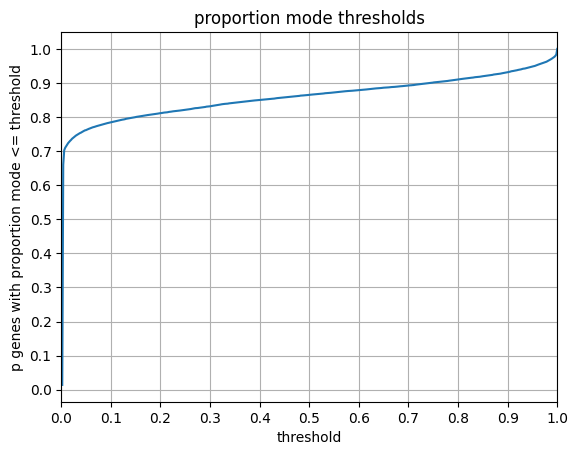

In [18]:
ax = p_mode\
    .value_counts()\
    .sort_index(ascending=True)\
    .cumsum()\
    .div(len(variance))\
    .plot(grid=True)
ax.set_title('proportion mode thresholds')
ax.set_xlabel('threshold')
ax.set_ylabel('p genes with proportion mode <= threshold')
ax.set_xticks(np.arange(0, variance.max(), .1))
ax.set_xlim((0, 1))
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_xlim((0, 1))

# distributions of some basic stats

Text(0.5, 0, '')

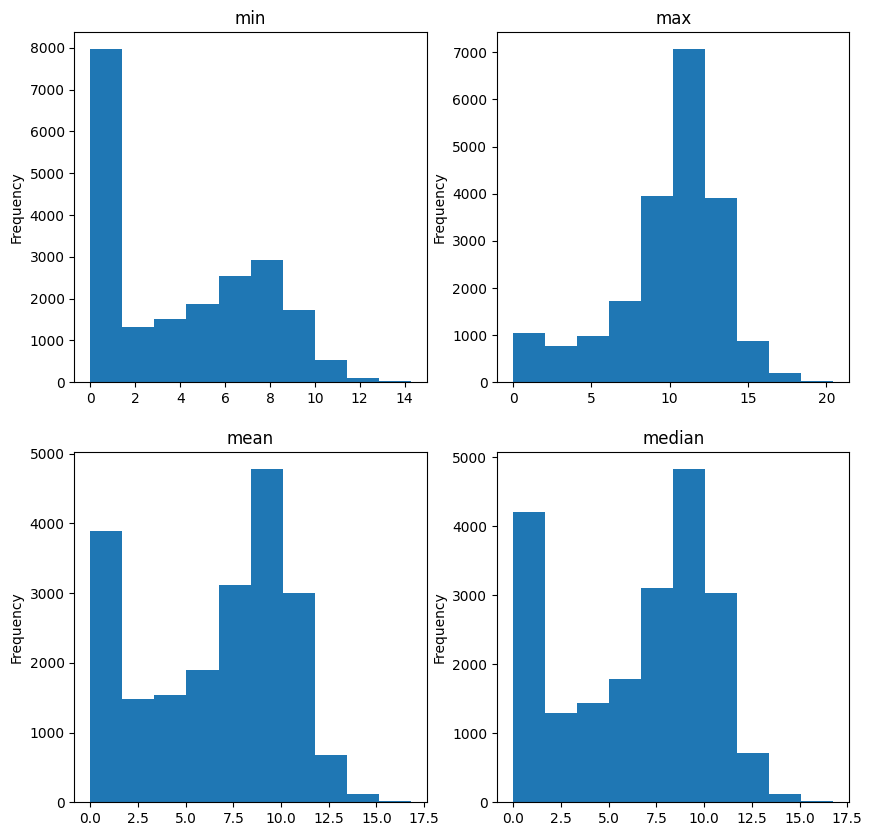

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

expression.min().plot(kind='hist', ax=axes[0,0], subplots=True)
axes[0, 0].set_title('min')
axes[0, 0].set_xlabel('')

expression.max().plot(kind='hist', ax=axes[0,1], subplots=True)
axes[0, 1].set_title('max')
axes[0, 1].set_xlabel('')

expression.mean().plot(kind='hist', ax=axes[1,0], subplots=True)
axes[1, 0].set_title('mean')
axes[1, 0].set_xlabel('')

expression.median().plot(kind='hist', ax=axes[1,1], subplots=True)
axes[1, 1].set_title('median')
axes[1, 1].set_xlabel('')

# spike of low min values (zeros)
# the mean and median look quite similar

# remove genes

In [20]:
n_genes_before = expression.shape[1]
expression = expression.loc[:, (p_mode <= .1) & (p_zero <= 1) & (variance >= 0)]
n_genes_removed = n_genes_before - expression.shape[1]
print(f'removed {n_genes_removed:,} genes ({n_genes_removed / n_genes_before:.1%})')

removed 4,426 genes (21.6%)


# PCA

In [21]:
X = expression
X.shape

(506, 16104)

In [22]:
varthresh = VarianceThreshold(threshold=1e-5)
X_varthresh = varthresh.fit_transform(X)
X_varthresh = pd.DataFrame(X_varthresh, columns = varthresh.get_feature_names_out(), index=expression.index)
print(X_varthresh.shape)
print(X_varthresh.head())

(506, 16104)
                 ARHGEF10L    HIF3A    RNF10    RNF11    RNF13  ...     PTRF   BCL6B    GSTK1    SELP     SELS
TCGA-69-7978-01     9.9898   4.2598  10.3657  11.1718  10.5897  ...  12.7565  8.2668  11.2400  6.1209   9.8977
TCGA-62-8399-01    10.4257  11.6239  11.5489  11.0200   9.2843  ...  12.2100  8.5437  10.3491  8.6398   9.7315
TCGA-78-7539-01     9.6264   9.1362  11.6692  10.4679  10.4649  ...  10.6498  6.1814  11.1659  6.0970  10.3540
TCGA-73-4658-01     9.2078   5.0288  11.6209  11.3414  10.9376  ...  13.0036  8.9786  10.6777  8.4187  10.3142
TCGA-44-6775-01    10.0039   4.0573  11.1721  11.0969  10.9337  ...  12.7727  7.5911  10.3340  7.3311  10.0039

[5 rows x 16104 columns]


In [23]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_varthresh)
X_scaled = pd.DataFrame(X_scaled, columns = X_varthresh.columns, index=expression.index)
print(X_scaled.shape)
print(X_scaled.head())

(506, 16104)
                 ARHGEF10L     HIF3A     RNF10     RNF11     RNF13  ...      PTRF     BCL6B     GSTK1      SELP  \
TCGA-69-7978-01   0.571589 -1.188462 -3.910672  0.583076  0.143260  ...  1.114916  0.557583  0.549584 -0.327663   
TCGA-62-8399-01   1.123841  2.143163 -0.616374  0.262925 -2.415989  ...  0.519487  0.879172 -0.751176  1.393088   
TCGA-78-7539-01   0.111189  1.017692 -0.281431 -0.901473 -0.101411  ... -1.180399 -1.864379  0.441394 -0.343990   
TCGA-73-4658-01  -0.419145 -0.840555 -0.415910  0.940769  0.825321  ...  1.384139  1.384260 -0.271403  1.242047   
TCGA-44-6775-01   0.589453 -1.280076 -1.665471  0.425110  0.817675  ...  1.132566 -0.227168 -0.773222  0.499068   

                     SELS  
TCGA-69-7978-01 -0.810045  
TCGA-62-8399-01 -1.104184  
TCGA-78-7539-01 -0.002492  
TCGA-73-4658-01 -0.072929  
TCGA-44-6775-01 -0.622094  

[5 rows x 16104 columns]


In [24]:
# pca = PCA(n_components=10, svd_solver='randomized')
pca = PCA(n_components=X_scaled.shape[0], svd_solver='randomized')
X_pca = pca.fit_transform(X_scaled)
X_pca = pd.DataFrame(X_pca, index=expression.index, columns=[f'pca_{x+1}' for x in range(pca.n_components)])
print(X_pca.shape)
print(X_pca.head())

(506, 506)
                     pca_1      pca_2      pca_3      pca_4      pca_5  ...   pca_502   pca_503   pca_504   pca_505  \
TCGA-69-7978-01 -31.700006  43.809999   7.441001  37.834125 -10.900391  ...  0.125233  0.376965 -0.802060  0.091882   
TCGA-62-8399-01 -15.430885  16.358135 -49.990986   2.518673  -1.918685  ... -0.170066  0.318224  0.364087 -0.452829   
TCGA-78-7539-01  -2.932173 -29.583563   3.937932 -16.505601  -6.002326  ... -0.598507 -0.082278 -0.158302 -0.097474   
TCGA-73-4658-01  -4.795971  15.263004  53.361986   9.389848 -34.349787  ... -0.688244 -0.434410 -0.303232  0.271187   
TCGA-44-6775-01 -37.359524  34.700233  16.328475  16.602021   0.067222  ...  1.862347  0.180420  1.600832 -1.221048   

                      pca_506  
TCGA-69-7978-01 -1.754085e-14  
TCGA-62-8399-01 -1.754085e-14  
TCGA-78-7539-01 -1.754085e-14  
TCGA-73-4658-01 -1.754085e-14  
TCGA-44-6775-01 -1.754085e-14  

[5 rows x 506 columns]


In [25]:
W = pd.DataFrame(pca.components_, columns=X_scaled.columns, index=[f'pca_{x+1}' for x in range(pca.n_components)])
print(W.shape)
print(W.head())

(506, 16104)
       ARHGEF10L     HIF3A     RNF10     RNF11     RNF13  ...      PTRF     BCL6B     GSTK1      SELP      SELS
pca_1  -0.008419 -0.006360 -0.000172  0.000649  0.001729  ... -0.012462 -0.010249  0.002196 -0.014863  0.010234
pca_2  -0.007663 -0.003303 -0.002368  0.006848  0.003319  ...  0.003585  0.003178 -0.010820 -0.000693 -0.003033
pca_3  -0.001320 -0.006637 -0.010867  0.014674  0.019328  ...  0.009092  0.003665  0.012566  0.008865  0.005870
pca_4   0.013774 -0.006127 -0.001421 -0.006317 -0.007471  ...  0.012726  0.007122  0.007791 -0.003141 -0.004619
pca_5  -0.003349  0.008038 -0.005766  0.001554  0.007487  ... -0.013744 -0.005920 -0.003608  0.001731  0.003452

[5 rows x 16104 columns]


Text(0, 0.5, 'pca2')

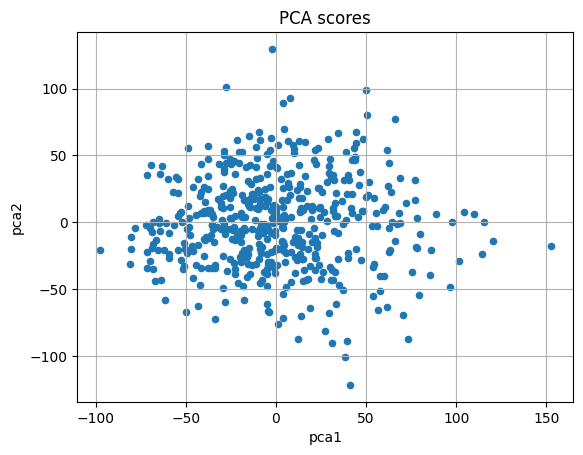

In [26]:
ax = X_pca.plot(kind='scatter', x='pca_1', y='pca_2', title='PCA scores', grid=True)
ax.set_xlabel('pca1')
ax.set_ylabel('pca2')

## cumulative variance explained

In [27]:
# cumulative variance explained by principal components
cum_var_exp = pd.Series(pca.explained_variance_ratio_).cumsum()
cum_var_exp.index = cum_var_exp.index + 1
cum_var_exp

1      0.094863
2      0.168131
3      0.233189
4      0.286043
5      0.322662
         ...   
502    0.999574
503    0.999720
504    0.999862
505    1.000000
506    1.000000
Length: 506, dtype: float64

In [28]:
# check cumulative variance explained for a selection of num components
cum_var_exp.loc[np.linspace(50, 500, 10)]

50     0.671346
100    0.780286
150    0.841661
200    0.883935
250    0.915596
300    0.940487
350    0.960477
400    0.976627
450    0.989548
500    0.999277
dtype: float64

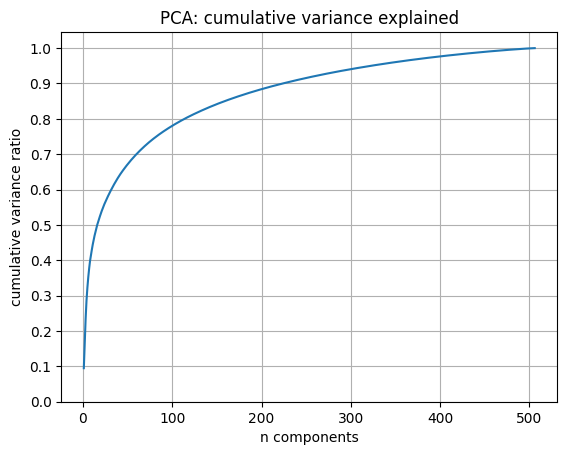

In [29]:
ax = cum_var_exp.plot(grid=True)
ax.set_title('PCA: cumulative variance explained')
ax.set_xlabel('n components')
ax.set_ylabel('cumulative variance ratio')
ax.set_yticks(np.linspace(0, 1, 11))
None
# ax.axhline(1, color="grey")
# ax.axhline(cum_var_exp.loc[100], color="blue", linestyle="--")
# ax.axhline(cum_var_exp.loc[200], color="red", linestyle="--")
# ax.axhline(cum_var_exp.loc[300], color="green", linestyle="--")
# ax.axhline(cum_var_exp.loc[400], color="purple", linestyle="--")

# save

In [30]:
expression.to_parquet(data_dir_dst / 'expression.parquet', compression='snappy')
X_pca.to_parquet(data_dir_dst / 'pca.parquet', compression='snappy')